In [67]:
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import random
import numpy as np


# Loading the data

In [3]:
class ImageDataset:
    def __init__(self, directory):
        """
        Args:
            directory (string): Path to the directory with images.
        """
        self.directory = directory
        self.images = sorted([
            os.path.join(directory, fname) for fname in os.listdir(directory)
            if fname.lower().endswith(('.png', '.jpg', '.jpeg'))
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('L')  # Convert image to RGB
        
        image = np.array(image)  # Convert to NumPy array
        image = image / 255.0  # Normalize to [0, 1]
        return image

    def load_all_images(self):
        return [self.__getitem__(i) for i in range(len(self))]



In [4]:
transform = transforms.Compose([

    transforms.ToTensor(),  

])


In [5]:

base_directory = r""
noise_level_directory = os.path.join(base_directory, "noisy50") 
fixed_sigma = 50
original_directory = os.path.join(base_directory, "original_png")

noisy_dataset = ImageDataset(noise_level_directory)
clean_dataset = ImageDataset(original_directory)

noisy_images = noisy_dataset.load_all_images()
clean_images = clean_dataset.load_all_images()


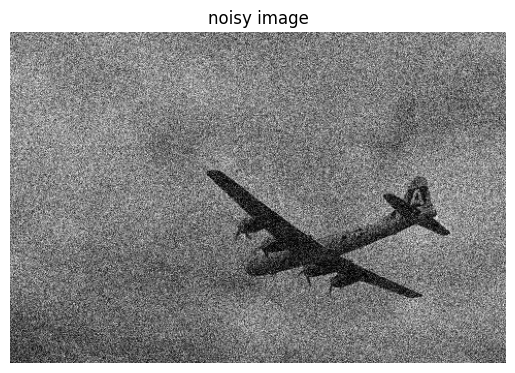

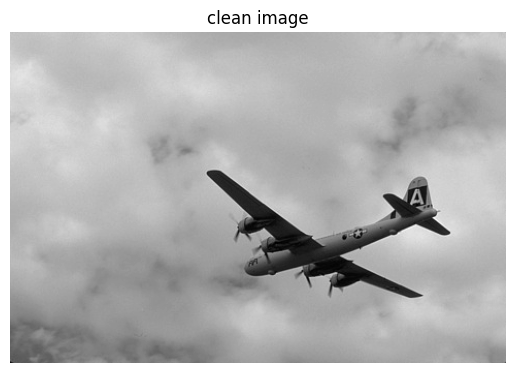

In [73]:

def display_image(image, title="Denoised Image"):

    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off') 
    plt.show()
    #return image 

display_image(noisy_dataset[0], "noisy image")
display_image(clean_dataset[0], "clean image")


# Algorithms

In [6]:
import bm3d
from skimage import io
from skimage.color import rgb2gray
import numpy as np
import cv2
from skimage.restoration import denoise_tv_chambolle

from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

In [7]:
def compute_average_psnr_ssim(denoised_dataset, clean_dataset):
    total_psnr = 0
    total_ssim = 0
    n_images = len(denoised_dataset)

    for i in range(n_images):
        denoised_image = denoised_dataset[i]
        clean_image = clean_dataset[i]
        
        
        # We Ensure the images are in the correct format, floating point, and within [0, 1]
        denoised_image = denoised_image.astype('float32') / 255
        clean_image = clean_image.astype('float32') 
        
        # Calculate PSNR and SSIM
        current_psnr = psnr(clean_image, denoised_image, data_range=1)
        current_ssim = ssim(clean_image, denoised_image, data_range=1)

        total_psnr += current_psnr
        total_ssim += current_ssim

    # Compute averages
    average_psnr = total_psnr / n_images
    average_ssim = total_ssim / n_images

    return average_psnr, average_ssim


## Non-local Means

In [192]:
lum = 20
nonlocal_means = []

for i, img in enumerate(noisy_dataset):
    # Convert the normalized image back to 8-bit format for OpenCV processing
    img_uint8 = np.uint8(img * 255)
    img_uint8 = cv2.cvtColor(img_uint8, cv2.COLOR_GRAY2BGR)  # Ensure the input is 3-channel

    # Apply Non-Local Means denoising
    denoised_img_color = cv2.fastNlMeansDenoisingColored(img_uint8, None, lum, 10, 7, 21)
    
    # Convert back to grayscale
    denoised_img_gray = cv2.cvtColor(denoised_img_color, cv2.COLOR_BGR2GRAY)

    nonlocal_means.append(denoised_img_gray)
    print(f"Denoised Image {i+1}: Shape = {denoised_img_gray.shape}, Data Type = {denoised_img_gray.dtype}")


Denoised Image 1: Shape = (321, 481), Data Type = uint8
Denoised Image 2: Shape = (321, 481), Data Type = uint8
Denoised Image 3: Shape = (321, 481), Data Type = uint8
Denoised Image 4: Shape = (321, 481), Data Type = uint8
Denoised Image 5: Shape = (321, 481), Data Type = uint8
Denoised Image 6: Shape = (321, 481), Data Type = uint8
Denoised Image 7: Shape = (321, 481), Data Type = uint8
Denoised Image 8: Shape = (481, 321), Data Type = uint8
Denoised Image 9: Shape = (481, 321), Data Type = uint8
Denoised Image 10: Shape = (481, 321), Data Type = uint8
Denoised Image 11: Shape = (481, 321), Data Type = uint8
Denoised Image 12: Shape = (321, 481), Data Type = uint8
Denoised Image 13: Shape = (321, 481), Data Type = uint8
Denoised Image 14: Shape = (321, 481), Data Type = uint8
Denoised Image 15: Shape = (321, 481), Data Type = uint8
Denoised Image 16: Shape = (321, 481), Data Type = uint8
Denoised Image 17: Shape = (321, 481), Data Type = uint8
Denoised Image 18: Shape = (321, 481), D

In [87]:
compute_average_psnr_ssim(nonlocal_means, clean_dataset)

(22.91120835518108, 0.5706982165051727)

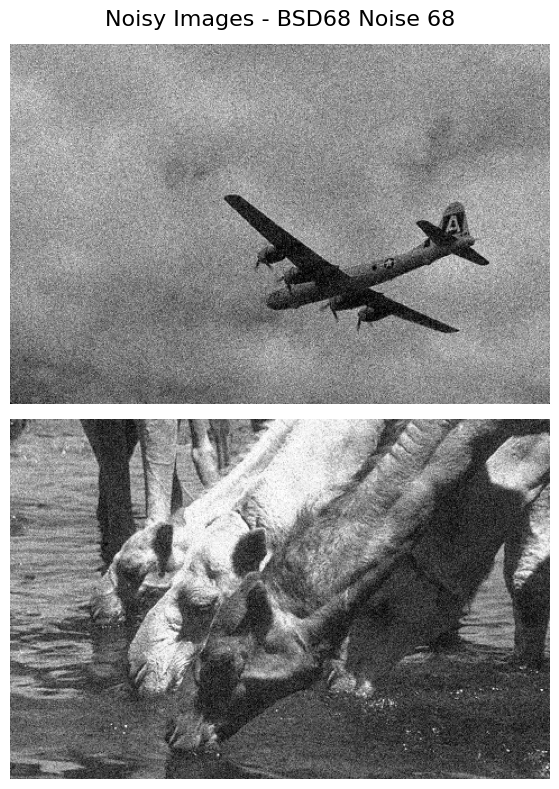

In [195]:

fig, axs = plt.subplots(2, 1, figsize=(6, 8))

# Display the first image
axs[0].imshow(noisy_dataset[0], cmap='gray')
axs[0].axis('off') 

# Display the second image
axs[1].imshow(noisy_dataset[3], cmap='gray')
axs[1].axis('off') 

plt.suptitle("Noisy Images - BSD68 Noise 68", fontsize=16)
plt.tight_layout()
plt.show()

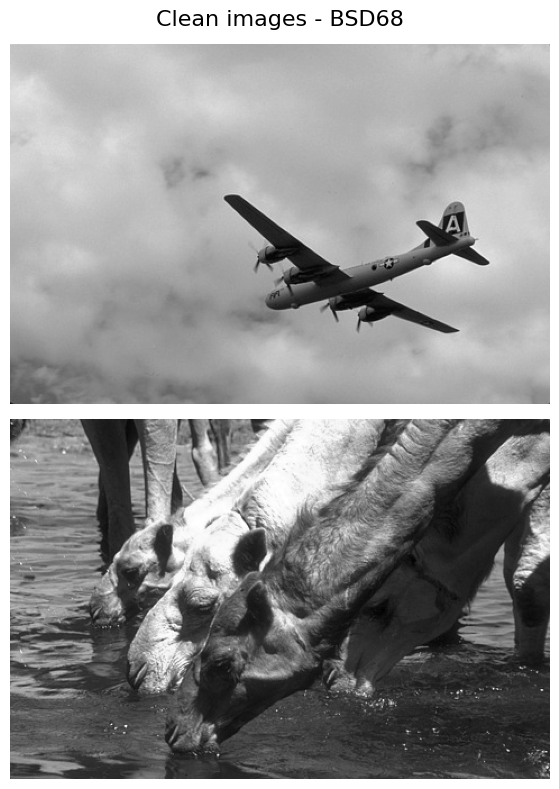

In [190]:

# Create a figure with 2 rows and 1 column
fig, axs = plt.subplots(2, 1, figsize=(6, 8))

# Display the first image
axs[0].imshow(clean_dataset[0], cmap='gray')
axs[0].axis('off')  # Hide the axes

# Display the second image
axs[1].imshow(clean_dataset[3], cmap='gray')
axs[1].axis('off')  # Hide the axes

# Adjust layout to make sure images are nicely placed
plt.suptitle("Clean images - BSD68", fontsize=16)
plt.tight_layout()
plt.show()

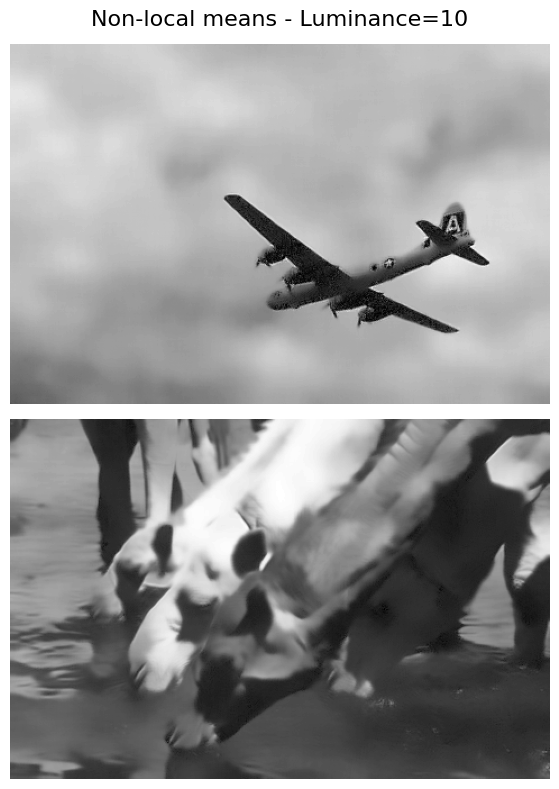

In [198]:


# Create a figure with 2 rows and 1 column
fig, axs = plt.subplots(2, 1, figsize=(6, 8))

# Display the first image
axs[0].imshow(nonlocal_means[0], cmap='gray')
axs[0].axis('off')  # Hide the axes

# Display the second image
axs[1].imshow(nonlocal_means[3], cmap='gray')
axs[1].axis('off')  # Hide the axes

# Adjust layout to make sure images are nicely placed
plt.suptitle("Non-local means - Luminance=10", fontsize=16)
plt.tight_layout()
plt.show()


## TV-Chambolle

In [201]:
tv_chambolle_denoised = []

for i, img in enumerate(noisy_dataset):
    # Convert the normalized image back to 8-bit format for OpenCV processing
    img_uint8 = np.uint8(img * 255)
    
    # Convert the image to grayscale (if not already in grayscale)
    if len(img_uint8.shape) == 3 and img_uint8.shape[2] == 3:
        img_gray = cv2.cvtColor(img_uint8, cv2.COLOR_BGR2GRAY)
    else:
        img_gray = img_uint8
    
    # Convert image to float format for TV Chambolle
    img_float = img_gray / 255.0

    # Apply TV Chambolle denoising
    denoised_img = denoise_tv_chambolle(img_float, weight=0.1)

    # Convert the denoised image back to 8-bit format
    denoised_img_uint8 = np.uint8(denoised_img * 255)

    tv_chambolle_denoised.append(denoised_img_uint8)
    print(f"Denoised Image {i+1}: Shape = {denoised_img_uint8.shape}, Data Type = {denoised_img_uint8.dtype}")

Denoised Image 1: Shape = (321, 481), Data Type = uint8
Denoised Image 2: Shape = (321, 481), Data Type = uint8
Denoised Image 3: Shape = (321, 481), Data Type = uint8
Denoised Image 4: Shape = (321, 481), Data Type = uint8
Denoised Image 5: Shape = (321, 481), Data Type = uint8
Denoised Image 6: Shape = (321, 481), Data Type = uint8
Denoised Image 7: Shape = (321, 481), Data Type = uint8
Denoised Image 8: Shape = (481, 321), Data Type = uint8
Denoised Image 9: Shape = (481, 321), Data Type = uint8
Denoised Image 10: Shape = (481, 321), Data Type = uint8
Denoised Image 11: Shape = (481, 321), Data Type = uint8
Denoised Image 12: Shape = (321, 481), Data Type = uint8
Denoised Image 13: Shape = (321, 481), Data Type = uint8
Denoised Image 14: Shape = (321, 481), Data Type = uint8
Denoised Image 15: Shape = (321, 481), Data Type = uint8
Denoised Image 16: Shape = (321, 481), Data Type = uint8
Denoised Image 17: Shape = (321, 481), Data Type = uint8
Denoised Image 18: Shape = (321, 481), D

In [202]:
compute_average_psnr_ssim(tv_chambolle_denoised, clean_dataset)

(27.124233682386333, 0.7598422501936041)

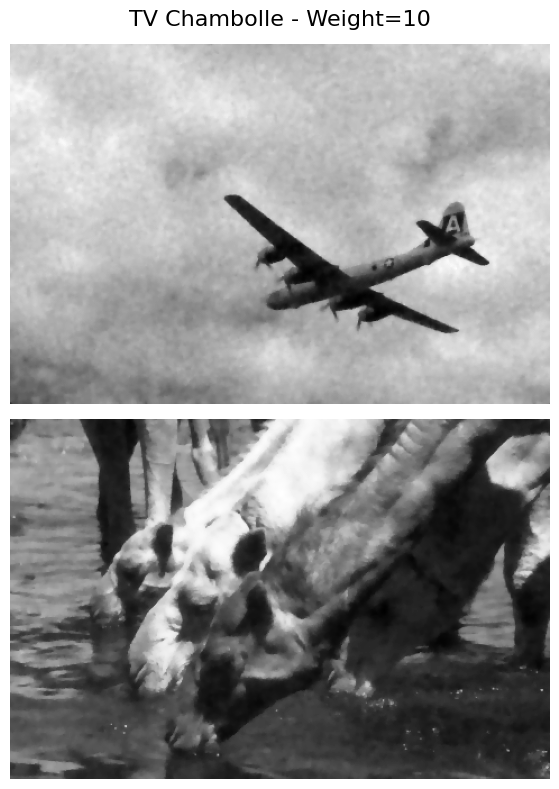

In [203]:

# Create a figure with 2 rows and 1 column
fig, axs = plt.subplots(2, 1, figsize=(6, 8))

# Display the first image
axs[0].imshow(tv_chambolle_denoised[0], cmap='gray')
axs[0].axis('off')  # Hide the axes

# Display the second image
axs[1].imshow(tv_chambolle_denoised[3], cmap='gray')
axs[1].axis('off')  # Hide the axes

# Adjust layout to make sure images are nicely placed
plt.suptitle("TV Chambolle - Weight=10", fontsize=16)
plt.tight_layout()
plt.show()


## Wavelet denoising

In [205]:
import numpy as np
import cv2
from skimage.restoration import denoise_wavelet
from matplotlib import pyplot as plt

wavelet_denoised = []

for i, img in enumerate(noisy_dataset):
    # Convert the normalized image back to 8-bit format for OpenCV processing
    img_uint8 = np.uint8(img * 255)
    
    # Convert the image to grayscale (if not already in grayscale)
    if len(img_uint8.shape) == 3 and img_uint8.shape[2] == 3:
        img_gray = cv2.cvtColor(img_uint8, cv2.COLOR_BGR2GRAY)
    else:
        img_gray = img_uint8
    
    # Convert image to float format for wavelet denoising
    img_float = img_gray / 255.0

    # Apply wavelet denoising
    denoised_img = denoise_wavelet(img_float, sigma=fixed_sigma/255)

    # Convert the denoised image back to 8-bit format
    denoised_img_uint8 = np.uint8(denoised_img * 255)

    wavelet_denoised.append(denoised_img_uint8)
    print(f"Denoised Image {i+1}: Shape = {denoised_img_uint8.shape}, Data Type = {denoised_img_uint8.dtype}")



Denoised Image 1: Shape = (321, 481), Data Type = uint8
Denoised Image 2: Shape = (321, 481), Data Type = uint8
Denoised Image 3: Shape = (321, 481), Data Type = uint8
Denoised Image 4: Shape = (321, 481), Data Type = uint8
Denoised Image 5: Shape = (321, 481), Data Type = uint8
Denoised Image 6: Shape = (321, 481), Data Type = uint8
Denoised Image 7: Shape = (321, 481), Data Type = uint8
Denoised Image 8: Shape = (481, 321), Data Type = uint8
Denoised Image 9: Shape = (481, 321), Data Type = uint8
Denoised Image 10: Shape = (481, 321), Data Type = uint8
Denoised Image 11: Shape = (481, 321), Data Type = uint8
Denoised Image 12: Shape = (321, 481), Data Type = uint8
Denoised Image 13: Shape = (321, 481), Data Type = uint8
Denoised Image 14: Shape = (321, 481), Data Type = uint8
Denoised Image 15: Shape = (321, 481), Data Type = uint8
Denoised Image 16: Shape = (321, 481), Data Type = uint8
Denoised Image 17: Shape = (321, 481), Data Type = uint8
Denoised Image 18: Shape = (321, 481), D

In [81]:
compute_average_psnr_ssim(wavelet_denoised, clean_dataset)

(22.362294402348176, 0.5468189853558143)

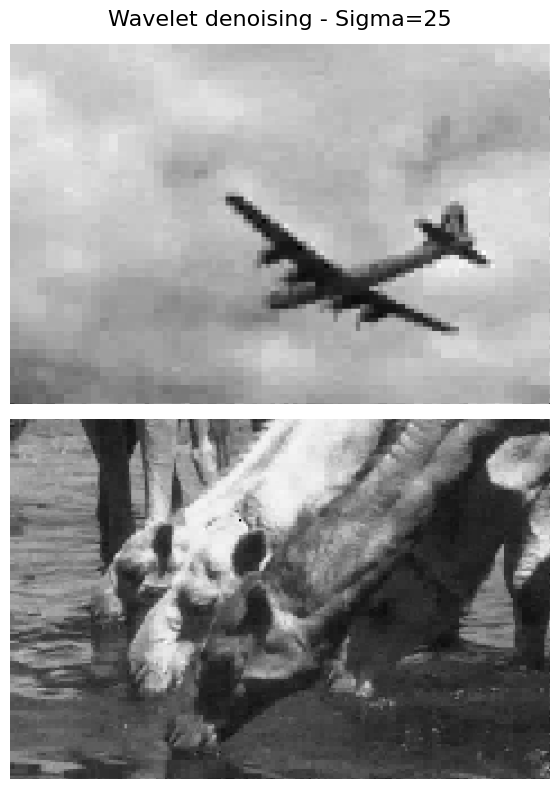

In [206]:

# Create a figure with 2 rows and 1 column
fig, axs = plt.subplots(2, 1, figsize=(6, 8))

# Display the first image
axs[0].imshow(wavelet_denoised[0], cmap='gray')
axs[0].axis('off')  # Hide the axes

# Display the second image
axs[1].imshow(wavelet_denoised[3], cmap='gray')
axs[1].axis('off')  # Hide the axes

# Adjust layout to make sure images are nicely placed
plt.suptitle("Wavelet denoising - Sigma=25", fontsize=16)
plt.tight_layout()
plt.show()


## PCA

In [214]:
import numpy as np
import cv2
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

pca_denoised = []

for i, img in enumerate(noisy_dataset):
    # Convert the normalized image back to 8-bit format for OpenCV processing
    img_uint8 = np.uint8(img * 255)
    
    # Convert the image to grayscale (if not already in grayscale)
    if len(img_uint8.shape) == 3 and img_uint8.shape[2] == 3:
        img_gray = cv2.cvtColor(img_uint8, cv2.COLOR_BGR2GRAY)
    else:
        img_gray = img_uint8
    
    # Normalize the grayscale image to [0, 1]
    img_float = img_gray / 255.0

    # Flatten the image
    original_shape = img_float.shape
    img_flattened = img_float.flatten().reshape(1, -1)

    # Apply PCA
    pca = PCA(n_components=0.975)  # Retain 95% of variance
    img_pca = pca.fit_transform(img_flattened)
    img_restored = pca.inverse_transform(img_pca)

    # Reshape the image back to its original shape
    img_restored = img_restored.reshape(original_shape)

    # Convert the denoised image back to 8-bit format
    denoised_img_uint8 = np.uint8(img_restored * 255)

    pca_denoised.append(denoised_img_uint8)
    print(f"Denoised Image {i+1}: Shape = {denoised_img_uint8.shape}, Data Type = {denoised_img_uint8.dtype}")


c:\Users\Filippo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\decomposition\_pca.py:557: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
c:\Users\Filippo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\decomposition\_pca.py:557: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
c:\Users\Filippo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\decomposition\_pca.py:557: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
c:\Users\Filippo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\decomposition\_pca.py:557: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
c:\Users\Filippo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\decomposition\_pca.py:557: RuntimeWarning: invalid value encountered in d

Denoised Image 1: Shape = (321, 481), Data Type = uint8
Denoised Image 2: Shape = (321, 481), Data Type = uint8
Denoised Image 3: Shape = (321, 481), Data Type = uint8
Denoised Image 4: Shape = (321, 481), Data Type = uint8
Denoised Image 5: Shape = (321, 481), Data Type = uint8
Denoised Image 6: Shape = (321, 481), Data Type = uint8
Denoised Image 7: Shape = (321, 481), Data Type = uint8
Denoised Image 8: Shape = (481, 321), Data Type = uint8
Denoised Image 9: Shape = (481, 321), Data Type = uint8
Denoised Image 10: Shape = (481, 321), Data Type = uint8
Denoised Image 11: Shape = (481, 321), Data Type = uint8
Denoised Image 12: Shape = (321, 481), Data Type = uint8
Denoised Image 13: Shape = (321, 481), Data Type = uint8
Denoised Image 14: Shape = (321, 481), Data Type = uint8
Denoised Image 15: Shape = (321, 481), Data Type = uint8
Denoised Image 16: Shape = (321, 481), Data Type = uint8
Denoised Image 17: Shape = (321, 481), Data Type = uint8
Denoised Image 18: Shape = (321, 481), D

c:\Users\Filippo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\decomposition\_pca.py:557: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
c:\Users\Filippo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\decomposition\_pca.py:557: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
c:\Users\Filippo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\decomposition\_pca.py:557: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
c:\Users\Filippo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\decomposition\_pca.py:557: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
c:\Users\Filippo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\decomposition\_pca.py:557: RuntimeWarning: invalid value encountered in d

Denoised Image 28: Shape = (321, 481), Data Type = uint8
Denoised Image 29: Shape = (321, 481), Data Type = uint8
Denoised Image 30: Shape = (321, 481), Data Type = uint8
Denoised Image 31: Shape = (321, 481), Data Type = uint8
Denoised Image 32: Shape = (321, 481), Data Type = uint8
Denoised Image 33: Shape = (321, 481), Data Type = uint8
Denoised Image 34: Shape = (481, 321), Data Type = uint8
Denoised Image 35: Shape = (321, 481), Data Type = uint8
Denoised Image 36: Shape = (481, 321), Data Type = uint8
Denoised Image 37: Shape = (321, 481), Data Type = uint8
Denoised Image 38: Shape = (321, 481), Data Type = uint8
Denoised Image 39: Shape = (481, 321), Data Type = uint8
Denoised Image 40: Shape = (321, 481), Data Type = uint8
Denoised Image 41: Shape = (321, 481), Data Type = uint8
Denoised Image 42: Shape = (481, 321), Data Type = uint8
Denoised Image 43: Shape = (481, 321), Data Type = uint8
Denoised Image 44: Shape = (321, 481), Data Type = uint8
Denoised Image 45: Shape = (321

c:\Users\Filippo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\decomposition\_pca.py:557: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
c:\Users\Filippo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\decomposition\_pca.py:557: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
c:\Users\Filippo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\decomposition\_pca.py:557: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
c:\Users\Filippo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\decomposition\_pca.py:557: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
c:\Users\Filippo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\decomposition\_pca.py:557: RuntimeWarning: invalid value encountered in d

In [83]:
compute_average_psnr_ssim(pca_denoised, clean_dataset)

(18.33386003783001, 0.3307183597697106)

## BM3D

In [216]:
import numpy as np
import cv2
import bm3d
from matplotlib import pyplot as plt

bm3d_denoised = []

for i, img in enumerate(noisy_dataset):
    # Convert the normalized image back to 8-bit format for BM3D processing
    img_uint8 = np.uint8(img * 255)
    
    # Convert the image to grayscale (if not already in grayscale)
    if len(img_uint8.shape) == 3 and img_uint8.shape[2] == 3:
        img_gray = cv2.cvtColor(img_uint8, cv2.COLOR_BGR2GRAY)
    else:
        img_gray = img_uint8
    
    # Convert image to float format for BM3D
    img_float = img_gray / 255.0

    # Apply BM3D denoising
    denoised_img = bm3d.bm3d(img_float, sigma_psd=fixed_sigma/255.0)

    # Convert the denoised image back to 8-bit format
    denoised_img_uint8 = np.uint8(denoised_img * 255)

    bm3d_denoised.append(denoised_img_uint8)
    print(f"Denoised Image {i+1}: Shape = {denoised_img_uint8.shape}, Data Type = {denoised_img_uint8.dtype}")




Denoised Image 1: Shape = (321, 481), Data Type = uint8
Denoised Image 2: Shape = (321, 481), Data Type = uint8
Denoised Image 3: Shape = (321, 481), Data Type = uint8
Denoised Image 4: Shape = (321, 481), Data Type = uint8
Denoised Image 5: Shape = (321, 481), Data Type = uint8
Denoised Image 6: Shape = (321, 481), Data Type = uint8
Denoised Image 7: Shape = (321, 481), Data Type = uint8
Denoised Image 8: Shape = (481, 321), Data Type = uint8
Denoised Image 9: Shape = (481, 321), Data Type = uint8
Denoised Image 10: Shape = (481, 321), Data Type = uint8
Denoised Image 11: Shape = (481, 321), Data Type = uint8
Denoised Image 12: Shape = (321, 481), Data Type = uint8
Denoised Image 13: Shape = (321, 481), Data Type = uint8
Denoised Image 14: Shape = (321, 481), Data Type = uint8
Denoised Image 15: Shape = (321, 481), Data Type = uint8
Denoised Image 16: Shape = (321, 481), Data Type = uint8
Denoised Image 17: Shape = (321, 481), Data Type = uint8
Denoised Image 18: Shape = (321, 481), D

In [217]:
compute_average_psnr_ssim(bm3d_denoised, clean_dataset)

(28.578439448927178, 0.8010909672508946)

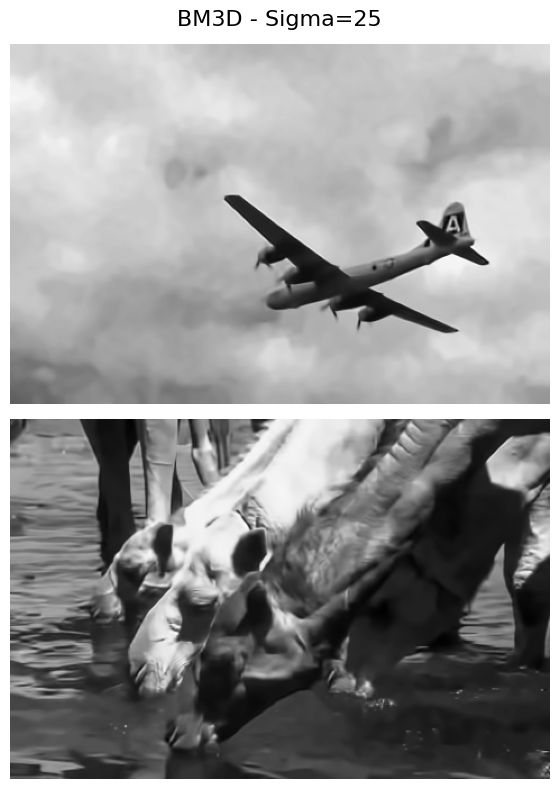

In [219]:
# Create a figure with 2 rows and 1 column
fig, axs = plt.subplots(2, 1, figsize=(6, 8))

# Display the first image
axs[0].imshow(bm3d_denoised[0], cmap='gray')
axs[0].axis('off')  # Hide the axes

# Display the second image
axs[1].imshow(bm3d_denoised[3], cmap='gray')
axs[1].axis('off')  # Hide the axes

# Adjust layout to make sure images are nicely placed
plt.suptitle("BM3D - Sigma=25", fontsize=16)
plt.tight_layout()
plt.show()

# Diffusion BM3D

In [ ]:
import os
import time
import numpy as np
from skimage import io
from skimage.color import rgb2gray
from bm3d import bm3d
from PIL import Image

def improved_bm3d_to_image(file_path, sigma_noise=25/255.0, save_path=None, num_iter=20, exp=1):
    # Load the image
    image = io.imread(file_path)
    
    # Convert to grayscale if it's not already
    if image.ndim == 3 and image.shape[2] == 3:
        image = rgb2gray(image)
    
    new_image = image
    for i in range(num_iter):
        alpha = ((i + 1) / num_iter) ** exp
        s = sigma_noise - sigma_noise * ((i / num_iter) ** exp)
        denoised_image = bm3d(new_image, sigma_psd=s)
        new_image = alpha * denoised_image + (1 - alpha) * image
    denoised_image = new_image

    # Convert the denoised image to uint8 format for saving
    denoised_image = np.clip(new_image * 255, 0, 255).astype('uint8')
    
    # Save the denoised image
    if save_path:
        Image.fromarray(denoised_image).save(save_path)

    return denoised_image

def denoise_directory_in_memory(source_directory, sigma_psd=25/255, num_iter=20, exp=1):
    denoised_images = []

    # Process each file in the source directory
    for filename in os.listdir(source_directory):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            file_path = os.path.join(source_directory, filename)
            
            # Apply BM3D denoising
            denoised_image = improved_bm3d_to_image(file_path, sigma_noise=sigma_psd, num_iter=num_iter, exp=exp)
            
            # Store the denoised image in memory
            denoised_images.append(denoised_image)
            print(f"Processed and stored in memory: {filename}")

    return denoised_images

# Example usage
source_dir = 'noisy25'
n = 20
pnsr_values2 = []
ssim_values2 = []
sample_images2 = []
processing_times = []

for i in range(1, 20):
    start_time = time.time()
    
    denoised_images_iter = denoise_directory_in_memory(source_dir, num_iter=i, exp=1)
    
    end_time = time.time()
    processing_time = end_time - start_time
    processing_times.append(processing_time)
    
    val = compute_average_psnr_ssim(denoised_images_iter, clean_dataset)
    print(f"{i} iterations:", val)
    print(f"Time for {i} iterations: {processing_time} seconds")
    
    pnsr_values2.append(val[0])
    ssim_values2.append(val[1])
    sample_images2.append(denoised_images_iter[0])

# At the end of the script, you can save or print the processing times array
print("Processing times for each iteration:", processing_times)


In [220]:
diff_bm3d_denoised_1 = denoise_directory_in_memory(source_dir, num_iter=5, exp=1)

Processed and stored in memory: 0000.png
Processed and stored in memory: 0001.png
Processed and stored in memory: 0002.png
Processed and stored in memory: 0003.png
Processed and stored in memory: 0004.png
Processed and stored in memory: 0005.png
Processed and stored in memory: 0006.png
Processed and stored in memory: 0007.png
Processed and stored in memory: 0008.png
Processed and stored in memory: 0009.png
Processed and stored in memory: 0010.png
Processed and stored in memory: 0011.png
Processed and stored in memory: 0012.png
Processed and stored in memory: 0013.png
Processed and stored in memory: 0014.png
Processed and stored in memory: 0015.png
Processed and stored in memory: 0016.png
Processed and stored in memory: 0017.png
Processed and stored in memory: 0018.png
Processed and stored in memory: 0019.png
Processed and stored in memory: 0020.png
Processed and stored in memory: 0021.png
Processed and stored in memory: 0022.png
Processed and stored in memory: 0023.png
Processed and st

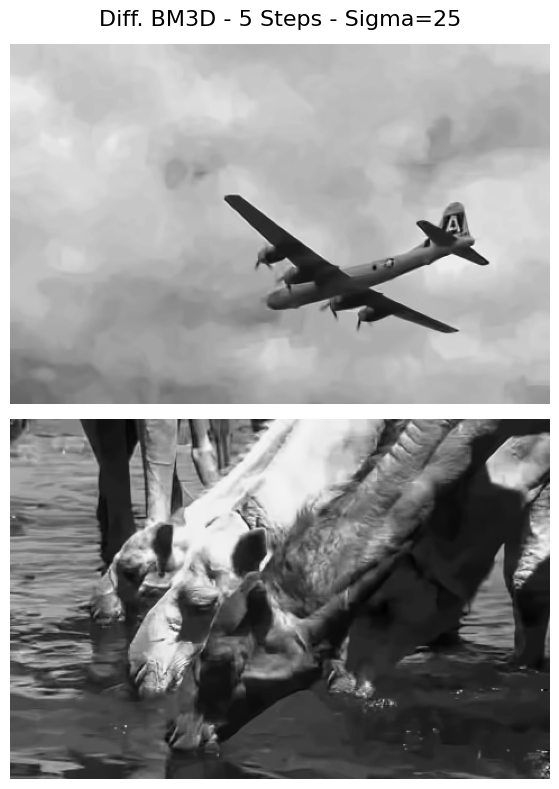

In [222]:
# Create a figure with 2 rows and 1 column
fig, axs = plt.subplots(2, 1, figsize=(6, 8))

# Display the first image
axs[0].imshow(diff_bm3d_denoised_1[0], cmap='gray')
axs[0].axis('off')  # Hide the axes

# Display the second image
axs[1].imshow(diff_bm3d_denoised_1[3], cmap='gray')
axs[1].axis('off')  # Hide the axes

# Adjust layout to make sure images are nicely placed
plt.suptitle("Diff. BM3D - 5 Steps - Sigma=25", fontsize=16)
plt.tight_layout()
plt.show()

In [223]:
diff_bm3d_denoised_2 = denoise_directory_in_memory(source_dir, num_iter=10, exp=1)

Processed and stored in memory: 0000.png
Processed and stored in memory: 0001.png
Processed and stored in memory: 0002.png
Processed and stored in memory: 0003.png
Processed and stored in memory: 0004.png
Processed and stored in memory: 0005.png
Processed and stored in memory: 0006.png
Processed and stored in memory: 0007.png
Processed and stored in memory: 0008.png
Processed and stored in memory: 0009.png
Processed and stored in memory: 0010.png
Processed and stored in memory: 0011.png
Processed and stored in memory: 0012.png
Processed and stored in memory: 0013.png
Processed and stored in memory: 0014.png
Processed and stored in memory: 0015.png
Processed and stored in memory: 0016.png
Processed and stored in memory: 0017.png
Processed and stored in memory: 0018.png
Processed and stored in memory: 0019.png
Processed and stored in memory: 0020.png
Processed and stored in memory: 0021.png
Processed and stored in memory: 0022.png
Processed and stored in memory: 0023.png
Processed and st

In [ ]:
# Create a figure with 2 rows and 1 column
fig, axs = plt.subplots(2, 1, figsize=(6, 8))

# Display the first image
axs[0].imshow(diff_bm3d_denoised_2[0], cmap='gray')
axs[0].axis('off')  # Hide the axes

# Display the second image
axs[1].imshow(diff_bm3d_denoised_2[3], cmap='gray')
axs[1].axis('off')  # Hide the axes

# Adjust layout to make sure images are nicely placed
plt.suptitle("Diff. BM3D - 5 Steps - Sigma=25", fontsize=16)
plt.tight_layout()
plt.show()

## Visualization

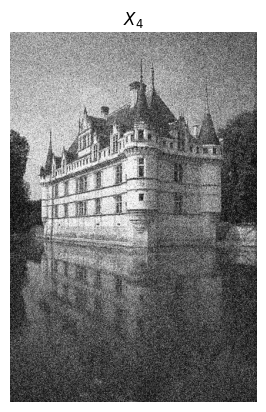

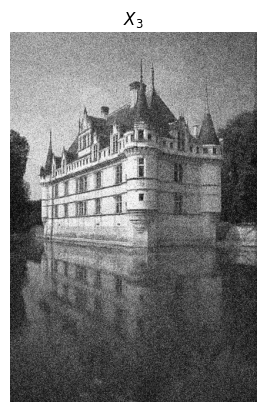

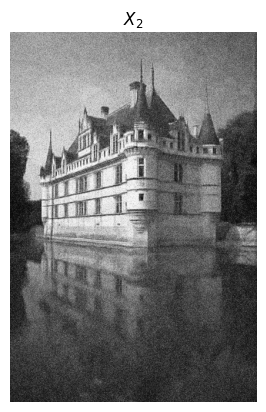

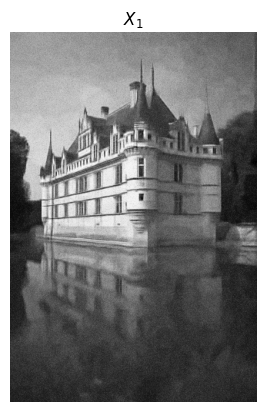

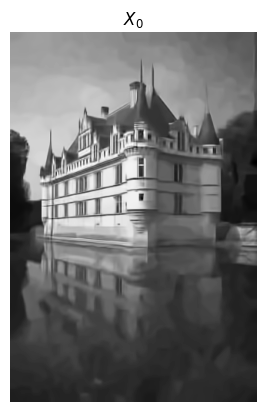

In [42]:
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
import bm3d

def improved_bm3d_to_image(image, sigma_noise=25/255.0, num_iter=20, exp=1):

    if image.ndim == 3 and image.shape[2] == 3:
        image = rgb2gray(image)
    
    new_image = image
    intermediate_images = []
    
    for i in range(num_iter):
        alpha = ((i + 1) / num_iter) ** exp
        s = sigma_noise - sigma_noise * ((i / num_iter) ** exp)
        denoised_image = bm3d.bm3d(new_image, sigma_psd=s)
        new_image = alpha * denoised_image + (1 - alpha) * image
        intermediate_images.append(new_image)
    
    return intermediate_images

# Example usage with a single image
def process_single_image(image, sigma_psd=50/255, num_iter=20, exp=1):

    # Apply BM3D denoising and get intermediate images
    intermediate_images = improved_bm3d_to_image(image, sigma_noise=sigma_psd, num_iter=num_iter, exp=exp)
    
    return intermediate_images


image = noisy_images[10]
intermediate_images = process_single_image(image, num_iter=5, exp=1)

def plot_intermediate_images(intermediate_images):
    for i, img in enumerate(intermediate_images):
        plt.figure()
        plt.imshow(img, cmap='gray')
        plt.title(f"$X_{{{4 - i}}}$")
        plt.axis('off')
        plt.show()

plot_intermediate_images(intermediate_images)


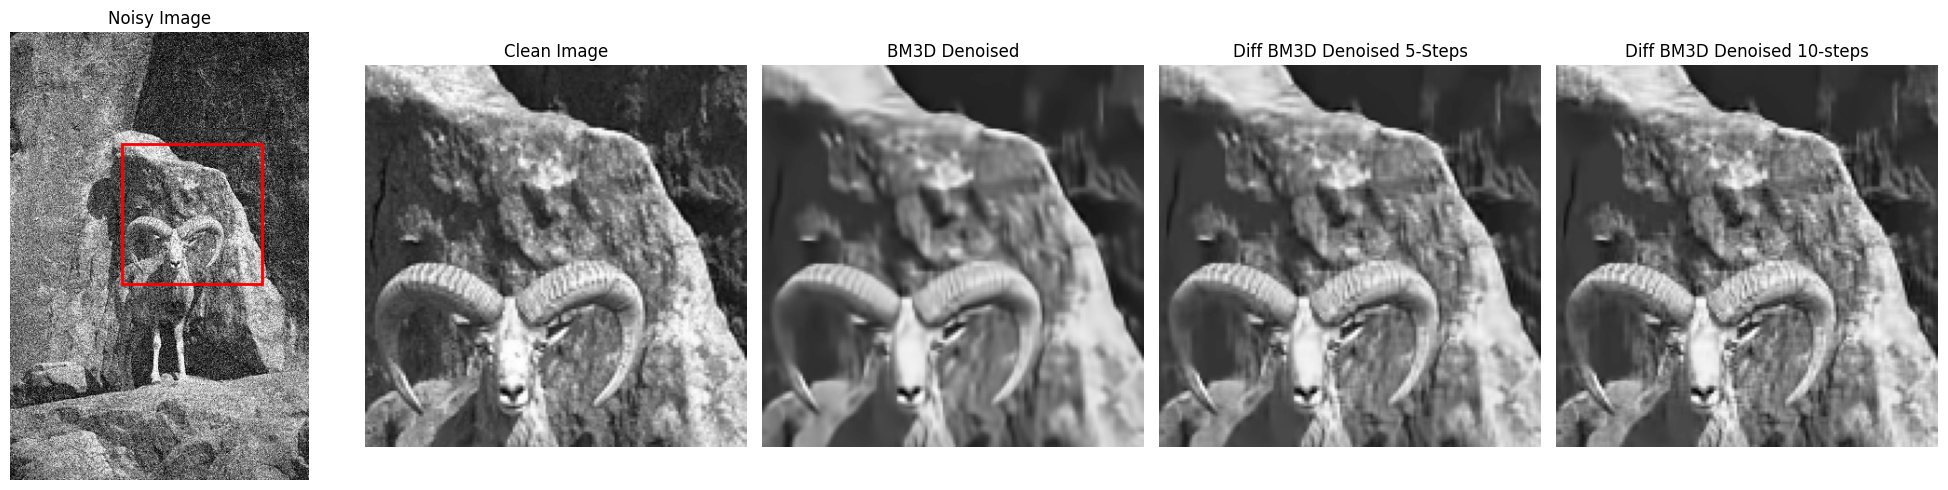

In [274]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np


def zoom_in(image_array, zoom_box):
    image = Image.fromarray(image_array)
    return image.crop(zoom_box)


ind = 65
noisy_image = noisy_images[ind]
denoised_images = [
    clean_images[ind] * 255,
    bm3d_denoised[ind],
    diff_bm3d_denoised_1[ind],
    diff_bm3d_denoised_2[ind]
]

# Array of titles for the zoomed images
titles = ['Clean Image', 'BM3D Denoised', 'Diff BM3D Denoised 5-Steps', 'Diff BM3D Denoised 10-steps']

# Define the region to zoom in (left, upper, right, lower)
zoom_box = (120, 120, 270, 270)  # Example coordinates, adjust as needed

# Create a figure with a grid of subplots
fig, axes = plt.subplots(1, len(denoised_images) + 1, figsize=(20, 5))

# Plot the noisy image on the left
axes[0].imshow(noisy_image, cmap='gray')
axes[0].add_patch(plt.Rectangle((zoom_box[0], zoom_box[1]), zoom_box[2] - zoom_box[0], zoom_box[3] - zoom_box[1],
                                edgecolor='red', facecolor='none', lw=2))
axes[0].set_title('Noisy Image')
axes[0].axis('off')

# Iterate over the denoised images and plot their zoomed-in regions
for idx, (image_array, title) in enumerate(zip(denoised_images, titles)):

    if image_array.dtype != np.uint8:
        image_array = (255 * (image_array - image_array.min()) / (image_array.max() - image_array.min())).astype(np.uint8)
    
    zoomed_image = zoom_in(image_array, zoom_box)
    axes[idx + 1].imshow(zoomed_image, cmap='gray')
    axes[idx + 1].set_title(f'{title}')
    axes[idx + 1].axis('off')

# Show the plot
plt.tight_layout()
plt.show()


## Plots

In [44]:
pnsr_values15 = [31.236710634153763,
 31.641814424660605,
 31.811981309471843,
 31.895453285262956,
 31.935661000883307,
 31.951349522411554,
 31.951149475449945,
 31.940668848574962,
 31.922715204412444,
 31.899983957483784,
 31.87330790793905,
 31.844302851975606,
 31.813234804528566,
 31.7801790934779,
 31.7468358238974,
 31.71268650528784,
 31.677737284747757,
 31.64251082784749,
 31.607389484615137]

ssim_values15 = [0.8789108675319379,
 0.8904811866662723,
 0.8965361307619747,
 0.9003755136074316,
 0.9030292285424194,
 0.904942814577785,
 0.906364399114517,
 0.9074324009318295,
 0.9082253745407285,
 0.9088047088222956,
 0.9092172542363939,
 0.9094994000241536,
 0.90965765397611,
 0.9097130764541685,
 0.9096957965712348,
 0.9096124846035152,
 0.909459821617775,
 0.9092531244639911,
 0.9090063577759667]

time_values15 = [82.79276633262634,
 161.60321927070618,
 239.22686457633972,
 314.186048746109,
 393.62418842315674,
 472.1942141056061,
 552.5930149555206,
 629.1024010181427,
 706.7765183448792,
 790.1550145149231,
 862.0366172790527,
 935.1047151088715,
 1015.6994924545288,
 1094.8773872852325,
 1171.1583199501038,
 1250.7855751514435,
 1326.7178373336792,
 1408.6244778633118,
 1489.707023859024]

print("max Pnsr ", max(pnsr_values15))
print("max Ssim ", max(ssim_values15))

max Pnsr  31.951349522411554
max Ssim  0.9097130764541685


In [47]:
pnsr_values25 = [28.456073931251346,
 28.83569090949811,
 29.03403172047642,
 29.155288130471714,
 29.234070819830464,
 29.286273354254632,
 29.319915623169646,
 29.34045538687336,
 29.3504459663409,
 29.353382885789333,
 29.35003340359227,
 29.341560684052524,
 29.32950110013102,
 29.314372938680084,
 29.296180784958295,
 29.275970131601284,
 29.254034420191935,
 29.229840967480442,
 29.204924768283597]

ssim_values25 = [0.8017269925961735,
 0.8160356213717544,
 0.8242746027832739,
 0.8298554803063474,
 0.8339568391536464,
 0.8371196864115321,
 0.8396237963135684,
 0.8416558939713702,
 0.8432867665297736,
 0.8446541966003597,
 0.8457696875887413,
 0.8466741996742467,
 0.8474276720874422,
 0.8480331728068699,
 0.8485174761835839,
 0.8488876153454803,
 0.8491641972525144,
 0.849352660445495,
 0.8494822635118724]

print("max Pnsr ", max(pnsr_values25))
print("max Ssim ", max(ssim_values25))


max Pnsr  29.353382885789333
max Ssim  0.8494822635118724


In [48]:
pnsr_values50 = [24.960992221597035,
 25.171077096076,
 25.295101708089224,
 25.384100722707498,
 25.452100843853078,
 25.506215766140794,
 25.55059542555724,
 25.588296051719695,
 25.62006473569088,
 25.646593836096617,
 25.669643952507517,
 25.689271454522057,
 25.706228639210856,
 25.72019517065437,
 25.73221440430868,
 25.742090600324886,
 25.750056344103164,
 25.756602747816004,
 25.761525337880038]

ssim_values50 = [0.6720021910082464,
 0.6842544669443057,
 0.6917904860399703,
 0.697322856078931,
 0.7016757780505728,
 0.7052241802258213,
 0.7082441808342493,
 0.7108522172113256,
 0.7131642920419594,
 0.7151564308941559,
 0.7169739899140255,
 0.7185856601016201,
 0.7200570792032707,
 0.7213859162357885,
 0.7225940635440671,
 0.7236953992728881,
 0.7246993210556517,
 0.7256306501928036,
 0.7264497023189248]

print("max Pnsr ", max(pnsr_values50))
print("max Ssim ", max(ssim_values50))


max Pnsr  25.761525337880038
max Ssim  0.7264497023189248


## Plotting results

### Noise 15

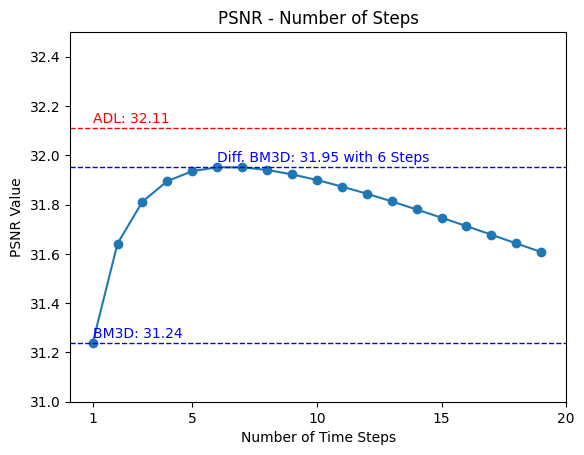

In [122]:

x_values = range(1, len(pnsr_values15) + 1)


# Find the maximum PSNR value and its index (time step)
max_psnr = max(pnsr_values15)
max_index = pnsr_values15.index(max_psnr) + 1
best_psnr = 32.11

# Create the plot
plt.plot(x_values, pnsr_values15, marker='o', linestyle='-')
plt.axhline(y=max_psnr, color='b', linestyle='--', linewidth=1)
plt.axhline(y=best_psnr, color='r', linestyle='--', linewidth=1)
plt.axhline(y=pnsr_values15[0], color='b', linestyle='--', linewidth=1)

# Add titles and labels
plt.title('PSNR - Number of Steps')
plt.xlabel('Number of Time Steps')
plt.ylabel('PSNR Value')

# Annotate the maximum value
plt.text(max_index, max_psnr + 0.01, f'Diff. BM3D: {max_psnr:.2f} with {max_index} Steps', 
         horizontalalignment='left', verticalalignment='bottom', color='b')
plt.text(1, best_psnr + 0.01, f'ADL: 32.11', 
         horizontalalignment='left', verticalalignment='bottom', color='r')
plt.text(1, pnsr_values15[0] + 0.01, f'BM3D: {pnsr_values15[0]:.2f} ', 
         horizontalalignment='left', verticalalignment='bottom', color='b')


plt.ylim(31, 32.5)  
plt.xticks([1, 5, 10, 15, 20])

# Show the plot
plt.show()

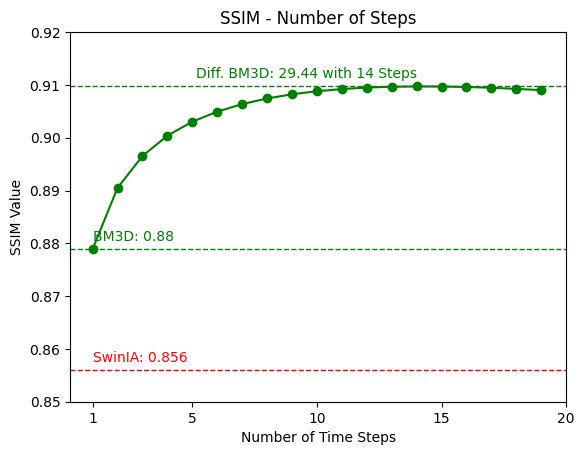

In [45]:

x_values = range(1, len(ssim_values15) + 1)


# Find the maximum PSNR value and its index (time step)
max_ssim = max(ssim_values15)
max_index = ssim_values15.index(max_ssim) + 1
best_ssim = 0.856

# Create the plot
plt.plot(x_values, ssim_values15, marker='o', linestyle='-',color='g')
plt.axhline(y=max_ssim, color='g', linestyle='--', linewidth=1)
plt.axhline(y=best_ssim, color='r', linestyle='--', linewidth=1)
plt.axhline(y=ssim_values15[0], color='g', linestyle='--', linewidth=1)

# Add titles and labels
plt.title('SSIM - Number of Steps')
plt.xlabel('Number of Time Steps')
plt.ylabel('SSIM Value')

# Annotate the maximum value
plt.text(max_index, max_ssim + 0.001, f'Diff. BM3D: {max_psnr:.2f} with {max_index} Steps', 
         horizontalalignment='right', verticalalignment='bottom', color='g')
plt.text(1, best_ssim + 0.001, f'SwinIA: 0.856', 
         horizontalalignment='left', verticalalignment='bottom', color='r')
plt.text(1, ssim_values15[0] + 0.001, f'BM3D: {ssim_values15[0]:.2f} ', 
         horizontalalignment='left', verticalalignment='bottom', color='g')


plt.ylim(0.85, 0.92) 
plt.xticks([1, 5, 10, 15, 20])

# Show the plot
plt.show()

### Noisy 25

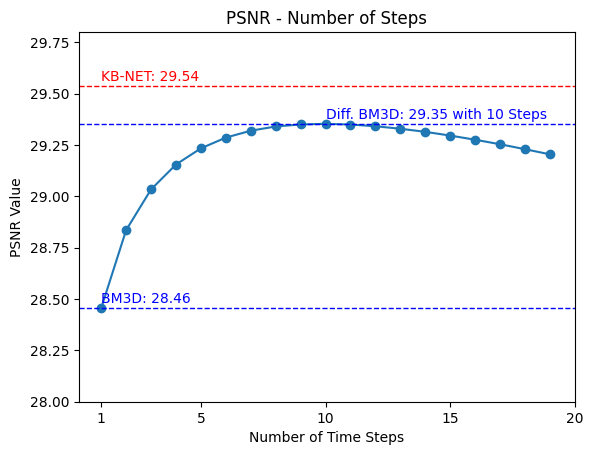

In [166]:
x_values = range(1, len(pnsr_values25) + 1)


# Find the maximum PSNR value and its index (time step)
max_psnr = max(pnsr_values25)
max_index = pnsr_values25.index(max_psnr) + 1
best_psnr = 29.54

# Create the plot
plt.plot(x_values, pnsr_values25, marker='o', linestyle='-')
plt.axhline(y=max_psnr, color='b', linestyle='--', linewidth=1)
plt.axhline(y=best_psnr, color='r', linestyle='--', linewidth=1)
plt.axhline(y=pnsr_values25[0], color='b', linestyle='--', linewidth=1)

# Add titles and labels
plt.title('PSNR - Number of Steps')
plt.xlabel('Number of Time Steps')
plt.ylabel('PSNR Value')

# Annotate the maximum value
plt.text(max_index, max_psnr + 0.01, f'Diff. BM3D: {max_psnr:.2f} with {max_index} Steps', 
         horizontalalignment='left', verticalalignment='bottom', color='b')
plt.text(1, best_psnr + 0.01, f'KB-NET: 29.54', 
         horizontalalignment='left', verticalalignment='bottom', color='r')
plt.text(1, pnsr_values25[0] + 0.01, f'BM3D: {pnsr_values25[0]:.2f} ', 
         horizontalalignment='left', verticalalignment='bottom', color='b')

plt.ylim(28, 29.8) 
plt.xticks([1, 5, 10, 15, 20])

# Show the plot
plt.show()

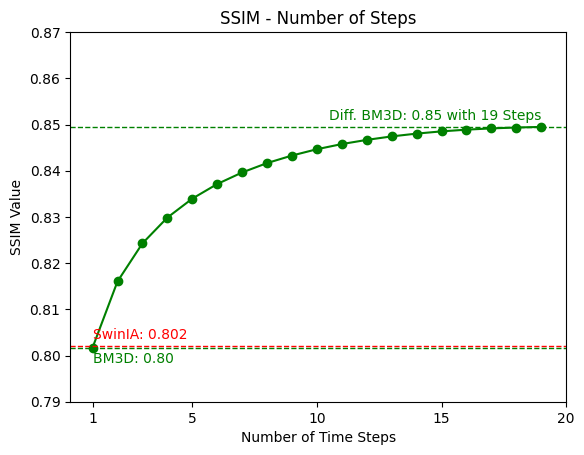

In [49]:
x_values = range(1, len(ssim_values25) + 1)


# Find the maximum PSNR value and its index (time step)
max_ssim = max(ssim_values25)
max_index = ssim_values25.index(max_ssim) + 1
best_ssim = 0.802

# Create the plot
plt.plot(x_values, ssim_values25, marker='o', linestyle='-', color='g')
plt.axhline(y=max_ssim, color='g', linestyle='--', linewidth=1)
plt.axhline(y=best_ssim, color='r', linestyle='--', linewidth=1)
plt.axhline(y=ssim_values25[0], color='g', linestyle='--', linewidth=1)

# Add titles and labels
plt.title('SSIM - Number of Steps')
plt.xlabel('Number of Time Steps')
plt.ylabel('SSIM Value')

# Annotate the maximum value
plt.text(max_index, max_ssim + 0.001, f'Diff. BM3D: {max_ssim:.2f} with {max_index} Steps', 
         horizontalalignment='right', verticalalignment='bottom', color='g')
plt.text(1, best_ssim + 0.001, f'SwinIA: 0.802', 
         horizontalalignment='left', verticalalignment='bottom', color='r')
plt.text(1, ssim_values25[0] - 0.004, f'BM3D: {ssim_values25[0]:.2f} ', 
         horizontalalignment='left', verticalalignment='bottom', color='g')

plt.ylim(0.79, 0.87) 
plt.xticks([1, 5, 10, 15, 20])


plt.show()

### Noisy 50

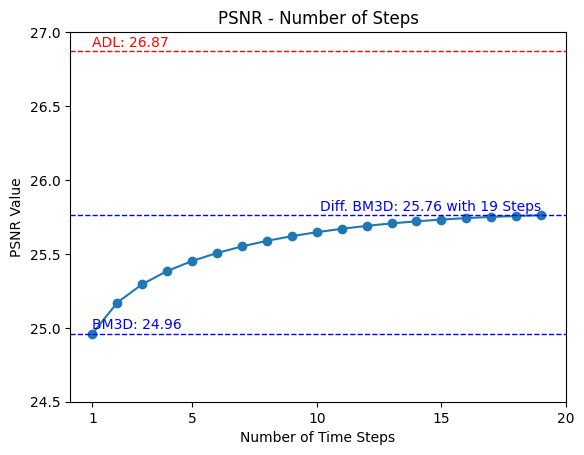

In [162]:
x_values = range(1, len(pnsr_values50) + 1)


# Find the maximum PSNR value and its index (time step)
max_psnr = max(pnsr_values50)
max_index = pnsr_values50.index(max_psnr) + 1
best_psnr = 26.87

# Create the plot
plt.plot(x_values, pnsr_values50, marker='o', linestyle='-')
plt.axhline(y=max_psnr, color='b', linestyle='--', linewidth=1)
plt.axhline(y=best_psnr, color='r', linestyle='--', linewidth=1)
plt.axhline(y=pnsr_values50[0], color='b', linestyle='--', linewidth=1)

# Add titles and labels
plt.title('PSNR - Number of Steps')
plt.xlabel('Number of Time Steps')
plt.ylabel('PSNR Value')

# Annotate the maximum value
plt.text(max_index, max_psnr + 0.01, f'Diff. BM3D: {max_psnr:.2f} with {max_index} Steps', 
         horizontalalignment='right', verticalalignment='bottom', color='b')
plt.text(1, best_psnr + 0.01, f'ADL: 26.87', 
         horizontalalignment='left', verticalalignment='bottom', color='r')
plt.text(1, pnsr_values50[0] + 0.01, f'BM3D: {pnsr_values50[0]:.2f} ', 
         horizontalalignment='left', verticalalignment='bottom', color='b')


plt.ylim(24.5, 27)  
plt.xticks([1, 5, 10, 15, 20])

plt.show()

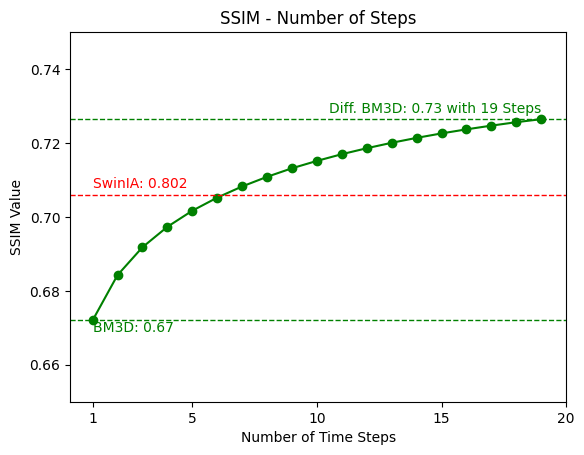

In [50]:
x_values = range(1, len(ssim_values50) + 1)


# Find the maximum PSNR value and its index (time step)
max_ssim = max(ssim_values50)
max_index = ssim_values50.index(max_ssim) + 1
best_ssim = 0.706

# Create the plot
plt.plot(x_values, ssim_values50, marker='o', linestyle='-',color='g')
plt.axhline(y=max_ssim, color='g', linestyle='--', linewidth=1)
plt.axhline(y=best_ssim, color='r', linestyle='--', linewidth=1)
plt.axhline(y=ssim_values50[0], color='g', linestyle='--', linewidth=1)

# Add titles and labels
plt.title('SSIM - Number of Steps')
plt.xlabel('Number of Time Steps')
plt.ylabel('SSIM Value')

# Annotate the maximum value
plt.text(max_index, max_ssim + 0.001, f'Diff. BM3D: {max_ssim:.2f} with {max_index} Steps', 
         horizontalalignment='right', verticalalignment='bottom', color='g')
plt.text(1, best_ssim + 0.001, f'SwinIA: 0.802', 
         horizontalalignment='left', verticalalignment='bottom', color='r')
plt.text(1, ssim_values50[0] - 0.004, f'BM3D: {ssim_values50[0]:.2f} ', 
         horizontalalignment='left', verticalalignment='bottom', color='g')


plt.ylim(0.65, 0.75) 
plt.xticks([1, 5, 10, 15, 20])

# Show the plot
plt.show()

# Non-linear diffusion Bm3d

In [ ]:


def improved_bm3d_to_image(file_path, sigma_noise=25/255.0, save_path=None, num_iter = 20, exp = 1):
    # Load the image
    image = io.imread(file_path)
    
    # Convert to grayscale if it's not already
    if image.ndim == 3 and image.shape[2] == 3:
        image = rgb2gray(image)
    
    
    new_image = image  # Start with the original noisy image
    for i in range(num_iter):
        # Calculate alpha using an exponential decay to increase the influence of the denoised image over time
        alpha = (i + 1) / num_iter
        alpha = alpha ** exp

        # Dynamically adjust the noise level, decreasing as the iterations progress
        s = sigma_noise * (1 - (i / num_iter) )

        # Apply BM3D denoising with the dynamically adjusted noise level
        denoised_image = bm3d.bm3d(new_image, sigma_psd=s, stage_arg=bm3d.BM3DStages.ALL_STAGES)

        # Blend the denoised image with the original image
        new_image = alpha * denoised_image + (1 - alpha) * image

    denoised_image = new_image
    
    # Convert the denoised image to uint8 format for saving
    denoised_image = np.clip(new_image * 255, 0, 255).astype('uint8')
    
    # Save the denoised image
    if save_path:
        Image.fromarray(denoised_image).save(save_path)

    return denoised_image

def denoise_directory_in_memory(source_directory, sigma_psd=25/250, num_iter = 20, exp = 4/5):
    denoised_images = []

    # Process each file in the source directory
    for filename in os.listdir(source_directory):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            file_path = os.path.join(source_directory, filename)
            
            # Apply BM3D denoising
            denoised_image = improved_bm3d_to_image(file_path, sigma_noise=sigma_psd, num_iter=num_iter, exp = exp)
            
            # Store the denoised image in memory
            denoised_images.append(denoised_image)
            print(f"Processed and stored in memory: {filename}")
        
       

    return denoised_images

# Example usage
source_dir = 'noisy25'
n =20 
pnsr_values2 = []
ssim_values2 = []
sample_images2 = []


for i in range(1,20):

    denoised_images_iter = denoise_directory_in_memory(source_dir, num_iter=i,exp = 3/2)

    val = compute_average_psnr_ssim(denoised_images_iter,clean_dataset)
    print(f"{i} iterations:", val)
    pnsr_values2.append(val[0])
    ssim_values2.append(val[1])
    sample_images2.append(denoised_images_iter[0])


In [53]:
pnsr_values2 = [28.380959782493157,
 29.250039496217248,
 29.438863700930757,
 29.438692664074072,
 29.365271915203717,
 29.257701823198833,
 29.13407065170758,
 29.002667949922113,
 28.8681241345136,
 28.7332530766305]
ssim_values2 = [0.7985738488140219,
 0.8361715032516419,
 0.8478809307643574,
 0.8524825064287667,
 0.8539714563849594,
 0.8537182610031955,
 0.8523921517765481,
 0.8503177251634915,
 0.847743909727126,
 0.8447700860759817]


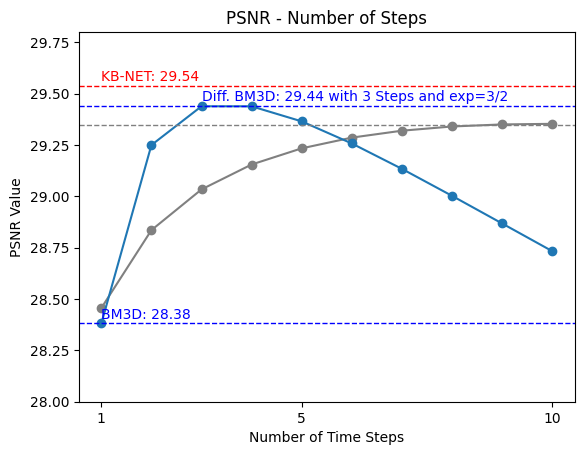

In [64]:
x_values = range(1, len(pnsr_values2) + 1)


# Find the maximum PSNR value and its index (time step)
max_psnr = max(pnsr_values2)
max_index = pnsr_values2.index(max_psnr) + 1
best_psnr = 29.54

# Create the plot
plt.plot(x_values, pnsr_values25[:10], marker='o', linestyle='-', color='gray')
plt.plot(x_values, pnsr_values2, marker='o', linestyle='-')
plt.axhline(y=max_psnr, color='b', linestyle='--', linewidth=1)
plt.axhline(y=best_psnr, color='r', linestyle='--', linewidth=1)
plt.axhline(y=pnsr_values2[0], color='b', linestyle='--', linewidth=1)
plt.axhline(y=29.35, color='gray', linestyle='--', linewidth=1)

# Add titles and labels
plt.title('PSNR - Number of Steps')
plt.xlabel('Number of Time Steps')
plt.ylabel('PSNR Value')

# Annotate the maximum value
plt.text(max_index, max_psnr + 0.01, f'Diff. BM3D: {max_psnr:.2f} with {max_index} Steps and exp=3/2', 
         horizontalalignment='left', verticalalignment='bottom', color='b')
plt.text(1, best_psnr + 0.01, f'KB-NET: 29.54', 
         horizontalalignment='left', verticalalignment='bottom', color='r')
plt.text(1, pnsr_values2[0] + 0.01, f'BM3D: {pnsr_values2[0]:.2f} ', 
         horizontalalignment='left', verticalalignment='bottom', color='b')

plt.ylim(28, 29.8)  
plt.xticks([1, 5, 10])

plt.show()

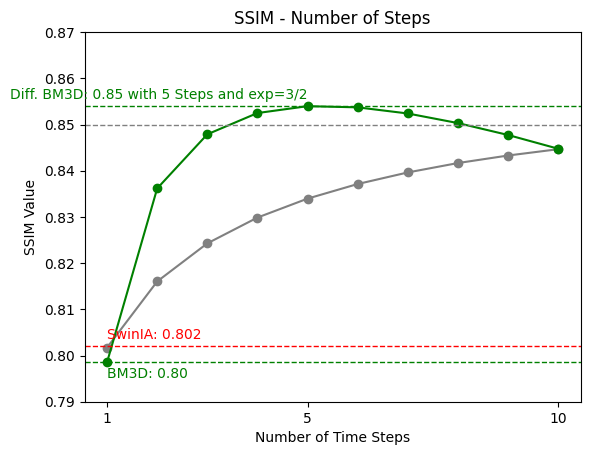

In [65]:
x_values = range(1, len(ssim_values2) + 1)


# Find the maximum PSNR value and its index (time step)
max_ssim = max(ssim_values2)
max_index = ssim_values2.index(max_ssim) + 1
best_ssim = 0.802

# Create the plot
plt.plot(x_values, ssim_values25[:10], marker='o', linestyle='-', color='gray')
plt.plot(x_values, ssim_values2, marker='o', linestyle='-', color='g')

plt.axhline(y=max_ssim, color='g', linestyle='--', linewidth=1)
plt.axhline(y=best_ssim, color='r', linestyle='--', linewidth=1)
plt.axhline(y=ssim_values2[0], color='g', linestyle='--', linewidth=1)
plt.axhline(y=0.85, color='gray', linestyle='--', linewidth=1)

# Add titles and labels
plt.title('SSIM - Number of Steps')
plt.xlabel('Number of Time Steps')
plt.ylabel('SSIM Value')

# Annotate the maximum value
plt.text(max_index, max_ssim + 0.001, f'Diff. BM3D: {max_ssim:.2f} with {max_index} Steps and exp=3/2', 
         horizontalalignment='right', verticalalignment='bottom', color='g')
plt.text(1, best_ssim + 0.001, f'SwinIA: 0.802', 
         horizontalalignment='left', verticalalignment='bottom', color='r')
plt.text(1, ssim_values2[0] - 0.004, f'BM3D: {ssim_values2[0]:.2f} ', 
         horizontalalignment='left', verticalalignment='bottom', color='g')

plt.ylim(0.79, 0.87)  
plt.xticks([1, 5, 10])

plt.show()